[0.06654673 0.09201499 0.20624909 ... 0.32555926 0.07275002 0.25236917]


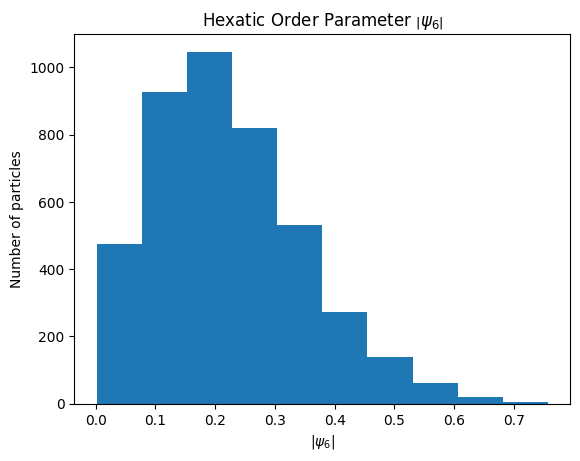

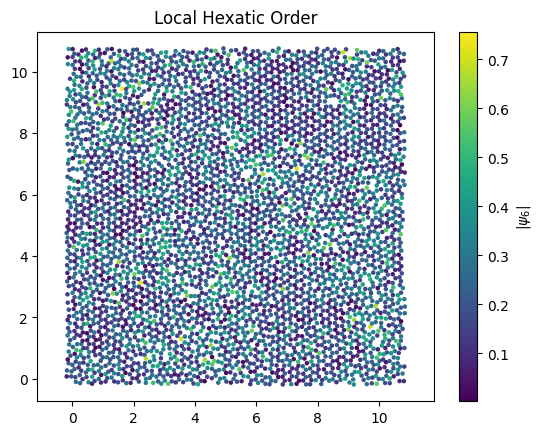

In [2]:
import mdtraj as md
import freud
import numpy as np
import matplotlib.pyplot as plt

# 1) Load your minimized LAMMPS trajectory with its PDB topology
traj = md.load_lammpstrj('hold.lammpstrj',
                         top='graphene_topology.pdb')

# 2) Extract the first frame’s XY coords and embed in 3D (z=0)
xy = traj.xyz[0, :, :2].astype(np.float32)       # (N,2)
points = np.zeros((xy.shape[0], 3), dtype=np.float32)
points[:, :2] = xy                               # (N,3)

# 3) Build a 2D box for freud by passing a length-2 list [Lx, Ly]
v1, v2, _ = traj.unitcell_vectors[0]
Lx, Ly = np.linalg.norm(v1), np.linalg.norm(v2)
box2d = [Lx, Ly]  # freud treats length-2 lists as 2D boxes :contentReference[oaicite:0]{index=0}

# 4) Compute per-particle hexatic order ψ₆
hexatic = freud.order.Hexatic(k=6)               # 2D hexatic (k-atic) order :contentReference[oaicite:1]{index=1}
hexatic.compute(system=(box2d, points))

psi6 = hexatic.particle_order                    # complex ψ₆ per particle
mag_psi6 = np.abs(psi6)                           # |ψ₆|
print(mag_psi6)

# 5a) Plot the distribution of |ψ₆|
ax = hexatic.plot()
ax.set_xlabel(r'$|\psi_6|$')
plt.show()

# 5b) Scatter-plot in real space, colored by local |ψ₆|
plt.figure()
plt.scatter(points[:, 0], points[:, 1], c=mag_psi6, s=5, cmap='viridis')
plt.axis('equal')
plt.colorbar(label=r'$|\psi_6|$')
plt.title('Local Hexatic Order')
plt.show()


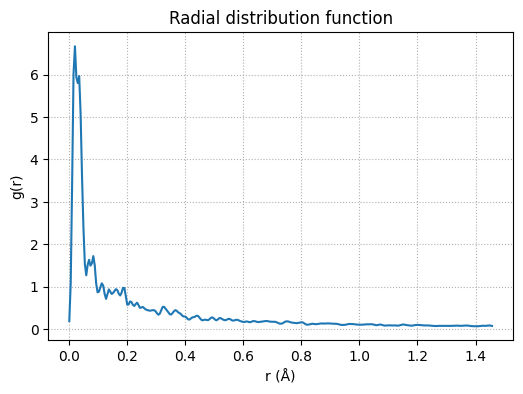

In [32]:
import mdtraj as md
import freud
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Load your dump + (PDB) topology
traj = md.load_lammpstrj('hold.lammpstrj',
                         top='graphene_topology.pdb')

# 1) Grab the first frame’s positions (these are fractions 0…1)
frac_pos = traj.xyz[0].astype(np.float32)  # shape (N,3)

# 2) Get your actual box vectors
cell = traj.unitcell_vectors[0]            # shape (3,3)
# Compute their lengths:
Lx, Ly, Lz = np.linalg.norm(cell, axis=1)

# 3) Convert to real positions
pos = np.empty_like(frac_pos)
pos[:, 0] = frac_pos[:, 0] * Lx
pos[:, 1] = frac_pos[:, 1] * Ly
pos[:, 2] = frac_pos[:, 2] * Lz

# 4) Build the freud box
box = freud.box.Box.from_box(cell)

# 5) Compute the RDF
r_max = min(Lx, Ly) / 15
rdf = freud.density.RDF(bins=300, r_max=r_max)
rdf.compute(system=(box, pos))

# 6) Plot g(r)
plt.figure(figsize=(6,4))
plt.plot(rdf.bin_centers*2, gaussian_filter1d(rdf.rdf,sigma=1.2))
plt.xlabel('r (Å)')
plt.ylabel('g(r)')
plt.title('Radial distribution function')
plt.grid(True, ls=':')
plt.show()


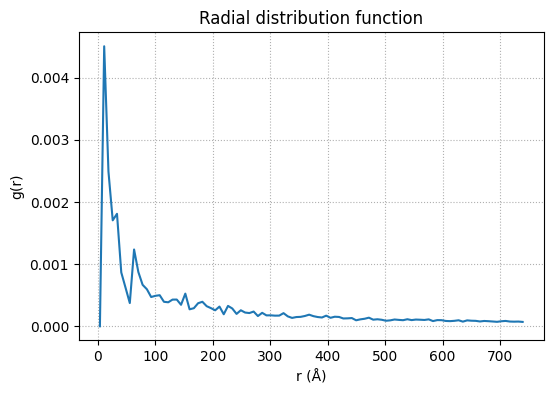

In [34]:
import mdtraj as md
import freud
import numpy as np
import matplotlib.pyplot as plt

# Load your dump + (PDB) topology
traj = md.load_lammpstrj('hold.lammpstrj',
                         top='graphene_topology.pdb')

# 1) Grab the first frame’s positions (these are fractions 0…1)
frac_pos = traj.xyz[0].astype(np.float32)  # shape (N,3)

# 2) Get your actual box vectors
cell = traj.unitcell_vectors[0]            # shape (3,3)
# Compute their lengths:
Lx, Ly, Lz = np.linalg.norm(cell, axis=1)

# 3) Convert to real positions
pos = np.empty_like(frac_pos)
pos[:, 0] = frac_pos[:, 0] * Lx
pos[:, 1] = frac_pos[:, 1] * Ly
pos[:, 2] = frac_pos[:, 2] * Lz

# 4) Build the freud box
box = freud.box.Box.from_box(cell)

# 5) Compute the RDF
r_max = min(Lx, Ly) / 15
rdf = freud.density.RDF(bins=100, r_max=r_max)
rdf.compute(system=(box, pos))

# 6) Plot g(r)
plt.figure(figsize=(6,4))
plt.plot(rdf.bin_centers*1000, rdf.rdf/1000)
plt.xlabel('r (Å)')
plt.ylabel('g(r)')
plt.title('Radial distribution function')
plt.grid(True, ls=':')
plt.show()


In [ ]:
import numpy as np
from scipy.spatial import cKDTree

# ──────────────────────────────────────────────────────────────────────
def minimum_image_vec(dxy, Lx, Ly):
    dxy[:, 0] -= np.round(dxy[:, 0] / Lx) * Lx
    dxy[:, 1] -= np.round(dxy[:, 1] / Ly) * Ly
    return dxy

# ──────────────────────────────────────────────────────────────────────
def compute_psi6(tree, pos, Lx, Ly, r_cut):
    """ψ6(i) with the *same* cKDTree used later for pairs."""
    nbr_lists = tree.query_ball_point(pos, r_cut)
    psi6 = np.empty(len(pos), dtype=np.complex128)

    for i, nbrs in enumerate(nbr_lists):
        if i in nbrs:
            nbrs.remove(i)
        if not nbrs:
            psi6[i] = 0.0
            continue
        vecs = pos[nbrs] - pos[i]
        vecs = minimum_image_vec(vecs, Lx, Ly)
        theta = np.arctan2(vecs[:, 1], vecs[:, 0])
        psi6[i] = np.exp(1j * 6.0 * theta).mean()
    return psi6

# ──────────────────────────────────────────────────────────────────────
def g6(pos, dr=0.1, r_max=None, r_cut=1.2):
    """
    Bond‑orientational correlation g6(r) without any bin‑threshold masking.
    Bins with zero pairs are returned as NaN so you can decide later whether
    to plot them, interpolate, etc.
    """
    # ----- box size ----------------------------------------------------
    Lx, Ly = np.ptp(pos[:, 0]), np.ptp(pos[:, 1])
    if r_max is None:
        r_max = 0.5 * min(Lx, Ly)

    # ----- neighbour tree ---------------------------------------------
    tree = cKDTree(pos)
    psi6 = compute_psi6(tree, pos, Lx, Ly, r_cut)
    psi6_mag2 = (np.abs(psi6) ** 2).mean()

    # ----- all pairs up to r_max --------------------------------------
    pairs = np.array(list(tree.query_pairs(r_max)))
    dxy = pos[pairs[:, 1]] - pos[pairs[:, 0]]
    dxy = minimum_image_vec(dxy, Lx, Ly)
    r = np.hypot(dxy[:, 0], dxy[:, 1])

    # ----- histogram ---------------------------------------------------
    nbins = int(np.ceil(r_max / dr))
    bin_idx = np.floor(r / dr).astype(np.int64)

    num = np.zeros(nbins, dtype=np.complex128)
    counts = np.bincount(bin_idx, minlength=nbins)
    weights = psi6[pairs[:, 0]] * np.conj(psi6[pairs[:, 1]])
    np.add.at(num, bin_idx, weights)

    # ----- g6(r) -------------------------------------------------------
    r_cent = (np.arange(nbins) + 0.5) * dr
    with np.errstate(divide="ignore", invalid="ignore"):
        g6_r = (num / counts).real / psi6_mag2   # keep the sign, drop abs()
    g6_r[counts == 0] = np.nan                  # bins with no statistics

    return r_cent, g6_r, counts                 # counts returned for reference

def g6_over_frames(frames,a, dr, r_cut):
    """
    frames  – iterable of (N,2) arrays, one per snapshot
    returns – r, g6_avg, counts_tot
    """
    g6_weighted_sum = counts_tot = None
    for pos in frames:
        r, g6_frame, counts = g6(pos / a, dr=dr, r_cut=r_cut)  # your existing func

        if g6_weighted_sum is None:          # first snapshot → allocate
            g6_weighted_sum = np.zeros_like(g6_frame, dtype=float)
            counts_tot      = np.zeros_like(counts,    dtype=int)
            r_cent          = r                       # same for all frames

        # accumulate
        g6_weighted_sum += g6_frame * counts
        counts_tot      += counts

    with np.errstate(divide="ignore", invalid="ignore"):
        g6_avg = g6_weighted_sum / counts_tot
    g6_avg[counts_tot == 0] = np.nan                 # empty bins → NaN

    return r_cent, g6_avg, counts_tot

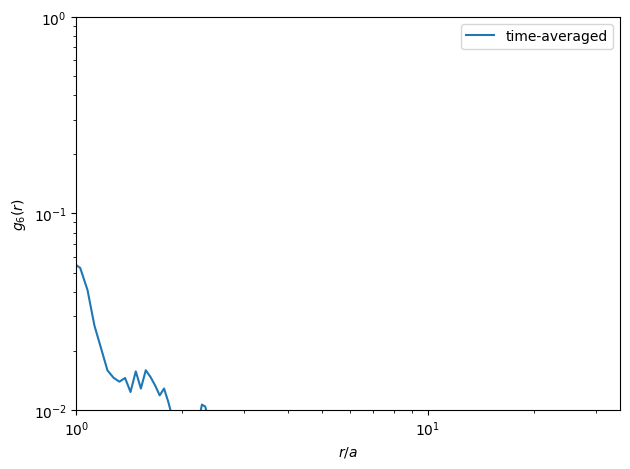

In [47]:
# 1) Load your minimized LAMMPS trajectory with its PDB topology
traj = md.load_lammpstrj('hold.lammpstrj',
                         top='graphene_topology.pdb')

traj = traj.xyz.astype(np.float32)  # shape (N,3)
a=1.42
r, g6_mean, counts = g6_over_frames(traj, a=1.42, dr=0.05, r_cut=1.2)

plt.loglog(r, g6_mean, label="time‑averaged")
plt.xlabel(r'$r/a$')
plt.ylabel(r'$g_6(r)$')
plt.xlim(1, 50/a)
plt.ylim(1e-2, 1)
plt.legend()
plt.tight_layout()
plt.show()